# DENUE analysis my block -test-

This notebook covers the first steps towards an urban land use classifier. In it:
1. The DENUE database is downloaded for a specific area
2. A classification of the DENUE by activity is assigned to each point
3. Each DENUE point gets assigned to an urban block
4. An iterative process produces a Kernel Density Estimation for each activity classification and each block

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
# import odc

from shapely.geometry import Point, Polygon

import seaborn as sns
import matplotlib.pyplot as plt

# from typing import Optional
from spatial_kde import spatial_kernel_density

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download and read data

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((662437.93 2284457.02, 662421.516 228..."


In [3]:
print(aoa_gdf.crs)

EPSG:32613


<Axes: >

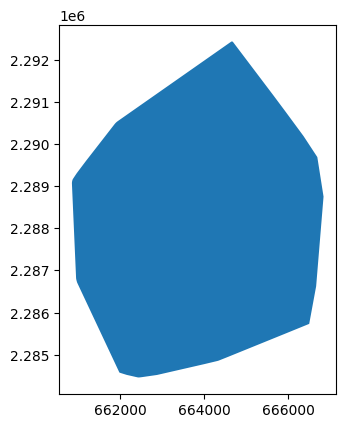

In [4]:
aoa_gdf.plot()

### DENUE

In [5]:
poly_wkt = aoa_gdf.dissolve().geometry.to_wkt()[0]

In [6]:
schema = "denue"
table = "denue_2022"

manzana = "manzana"
entidad = "cve_ent"
localidad = "cve_loc"
municipio = "cve_mun"
id = "id"
latitud = "latitud"
longitud = "longitud"
codigo_act = "codigo_act"
ageb = "ageb"
per_ocu = "per_ocu"


# Crear la consulta manteniendo el mismo CRS
query_censo = f"""
SELECT 
  "{id}", 
  "{entidad}",
  "{localidad}",
  "{manzana}",
  "{municipio}",
  "{latitud}",
  "{longitud}",
  "{codigo_act}",
  "{ageb}",
  "{per_ocu}",
  "geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta
denue_gdf = aup.gdf_from_query(query_censo, geometry_col='geometry')

# Asegurar que el GeoDataFrame resultante tenga el CRS correcto
denue_gdf = denue_gdf.to_crs("EPSG:32613")


print(denue_gdf.shape)
denue_gdf.head()

(7353, 11)


,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry
0,1699006,14,0001,010,120,20.677705,-103.447473,237131,3575,6 a 10 personas,POINT (661711.071 2287252.757)
1,1639611,14,0001,018,120,20.694152,-103.453771,314991,1206,6 a 10 personas,POINT (661037.629 2289067.252)
2,1698378,14,0001,020,120,20.675783,-103.418001,311830,2952,0 a 5 personas,POINT (664783.488 2287069.746)
3,8305530,14,0001,027,120,20.679851,-103.425109,311213,2416,11 a 30 personas,POINT (664038.607 2287512.869)
4,8649571,14,0001,016,120,20.664372,-103.413526,311421,4732,0 a 5 personas,POINT (665262.043 2285810.999)


### Census blocks

In [7]:
schema = "sociodemografico"
table = "censo_inegi_20_mza"


query_censo = f"""
SELECT 
"cvegeo_mza",
"pobtot",
"geometry"
FROM {schema}.{table}
WHERE ST_Intersects(
  ST_Transform(geometry, 32613),  -- Transformar geometría de DENUE a 32613 
  ST_GeomFromText('{poly_wkt}', 32613)  -- Usar el polígono en 32613
)
"""

# Ejecutar la consulta y cargar los datos en un GeoDataFrame
block_gdf = aup.gdf_from_query(query_censo, geometry_col='geometry')
block_gdf = block_gdf.to_crs("EPSG:32613")

print(block_gdf.shape)
block_gdf.head()

(1826, 3)


,cvegeo_mza,pobtot,geometry
0,1403900011274036,384,"POLYGON ((666477.605 2287242.897, 666485.728 2..."
1,1403900011274035,368,"POLYGON ((666580.993 2287272.531, 666604.924 2..."
2,1403900010562001,235,"POLYGON ((666978.885 2288708.665, 667009.74 22..."
3,1403900010562026,34,"POLYGON ((666644.174 2288436.014, 666667.842 2..."
4,1403900010562027,58,"POLYGON ((666582.8 2288243.358, 666525.87 2288..."


## Data treatment and preprocessing

### DENUE classification by activity

Clasificar las distintas actividades económicas con base en su terminación en "codigo_act" basándonos en el Directorio Estadístico Nacional de Unidades Económicas

In [8]:
# Función para clasificar según la terminación de codigo_act
def asignar_tipo(codigo):
    if pd.isna(codigo):  # Si está vacío
        return 'Sin código'
    
    # Asegurar que sea string para evaluar el código
    codigo_str = str(codigo).strip()

    if not codigo_str.isdigit():
        return 'Código inválido'
    
    # Define tus conjuntos de códigos
    industria = {'11', '21', '23', '31', '32', '33', '55'}
    
    servicios = {'22', '48', '49', '52', '53', '54', '56', '72',
                 '81'}
    
    comercio = {'43', '46'}
    
    cultural_recreativo = {'51','71'}
    
    educacion = {'61'}
    
    salud = {'62'}

    gobierno = {'93'}
    
    # Verificar si el código está en alguno de los conjuntos
    if codigo_str[:2] in industria:
        return 'Industria'
    elif codigo_str[:2] in servicios:
        return 'Servicios'
    elif codigo_str[:2] in comercio:
        return 'Comercio'
    elif codigo_str[:2] in cultural_recreativo:
        return 'Cultural_Recreativo'
    elif codigo_str[:2] in educacion:
        return 'Educación'
    elif codigo_str[:2] in salud:
        return 'Salud'
    elif codigo_str[:2] in gobierno:
        return 'Gobierno'
    else:
        return 'Desconocido'

# Aplica la función al DataFrame
denue_gdf['tipo_act'] = denue_gdf['codigo_act'].apply(asignar_tipo)

In [9]:
denue_gdf.head(3)

,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act
0,1699006,14,0001,010,120,20.677705,-103.447473,237131,3575,6 a 10 personas,POINT (661711.071 2287252.757),Industria
1,1639611,14,0001,018,120,20.694152,-103.453771,314991,1206,6 a 10 personas,POINT (661037.629 2289067.252),Industria
2,1698378,14,0001,020,120,20.675783,-103.418001,311830,2952,0 a 5 personas,POINT (664783.488 2287069.746),Industria


In [10]:
denue_gdf["tipo_act"].unique()

array(['Industria', 'Servicios', 'Comercio', 'Cultural_Recreativo',
       'Educación', 'Salud', 'Gobierno'], dtype=object)

In [11]:
len(denue_gdf[denue_gdf['tipo_act'] == 'Desconocido'])

0

### DENUE occupied personel

Contabilizar cuántas personas hay ejerciendo cada actividad económica

In [12]:
def number_of_jobs(per_ocu):
    jobs_dict = {'0 a 5 personas':3,
                '6 a 10 personas':8,
                '11 a 30 personas':20,
                '31 a 50 personas':40,
                '51 a 100 personas':75,
                '101 a 250 personas':175,
                '251 y más personas':325}
    per_ocu_num = jobs_dict[per_ocu]
    return per_ocu_num

In [13]:
denue_gdf['per_ocu_num'] = denue_gdf.per_ocu.apply(lambda per_ocu: number_of_jobs(per_ocu))
denue_gdf.head(2)

,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num
0,1699006,14,0001,010,120,20.677705,-103.447473,237131,3575,6 a 10 personas,POINT (661711.071 2287252.757),Industria,8
1,1639611,14,0001,018,120,20.694152,-103.453771,314991,1206,6 a 10 personas,POINT (661037.629 2289067.252),Industria,8


### DENUE to blocks

Create CVEGEO code for each DENUE

In [14]:
denue_gdf['cvegeo_mza'] = (
    denue_gdf['cve_ent'].astype(str).str[:2] +
    denue_gdf['cve_mun'].astype(str).str[:3] +
    denue_gdf['cve_loc'].astype(str).str[:4] +
    denue_gdf['ageb'].astype(str).str[:4] +
    denue_gdf['manzana'].astype(str).str[:3]
)
print(denue_gdf.shape)
denue_gdf.head(2)

(7353, 14)


,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza
0,1699006,14,0001,010,120,20.677705,-103.447473,237131,3575,6 a 10 personas,POINT (661711.071 2287252.757),Industria,8,1412000013575010
1,1639611,14,0001,018,120,20.694152,-103.453771,314991,1206,6 a 10 personas,POINT (661037.629 2289067.252),Industria,8,1412000011206018


In [15]:
denue_gdf.cvegeo_mza.apply(len).min() # checks if every element has a 16 character length

np.int64(16)

Test if every DENUE is assigned to a block

In [16]:
denue_gdf.merge(block_gdf[['cvegeo_mza','pobtot']], on='cvegeo_mza', how='inner').pobtot.isna().sum()

np.int64(0)

### Distance from DENUE to block centroids

In [17]:
# 1. Crear GeoDataFrame de manzanas con centroides únicos
block_cnt = block_gdf.copy()
block_cnt['cnt_geometry'] = block_cnt['geometry'].centroid

In [18]:
# 2. Merge block centroid geometry to DENUE gdf
denue_gdf = pd.merge(
    denue_gdf,
    block_cnt[['cvegeo_mza', 'cnt_geometry']],
    on=['cvegeo_mza'],
    how='inner'
)
print(denue_gdf.shape)
denue_gdf.head(2)

(7353, 15)


,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry
0,1699006,14,0001,010,120,20.677705,-103.447473,237131,3575,6 a 10 personas,POINT (661711.071 2287252.757),Industria,8,1412000013575010,POINT (661673.303 2287384.863)
1,1639611,14,0001,018,120,20.694152,-103.453771,314991,1206,6 a 10 personas,POINT (661037.629 2289067.252),Industria,8,1412000011206018,POINT (661169.341 2288689.642)


In [19]:
# 3. Calcular la distancia de cada punto al centroide de su manzana
denue_gdf['distancia'] = denue_gdf['geometry'].distance(denue_gdf['cnt_geometry'])

In [20]:
# 4. Calcular d_mean por manzana
denue_to_cnt = denue_gdf.groupby(
    ['cvegeo_mza']
)['distancia'].mean().reset_index(name='d_mean')
print(denue_to_cnt.shape)
denue_to_cnt.head(2)

(800, 2)


,cvegeo_mza,d_mean
0,1403900010562024,103.408153
1,1403900010562025,244.817595


In [21]:
# Add average distance to each block centroid
denue_gdf = denue_gdf.merge(denue_to_cnt, on='cvegeo_mza')
print(denue_gdf.shape)
denue_gdf.head(2)

(7353, 17)


,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,1699006,14,0001,010,120,20.677705,-103.447473,237131,3575,6 a 10 personas,POINT (661711.071 2287252.757),Industria,8,1412000013575010,POINT (661673.303 2287384.863),137.398385,128.665528
1,1639611,14,0001,018,120,20.694152,-103.453771,314991,1206,6 a 10 personas,POINT (661037.629 2289067.252),Industria,8,1412000011206018,POINT (661169.341 2288689.642),399.921166,359.041401


<Axes: >

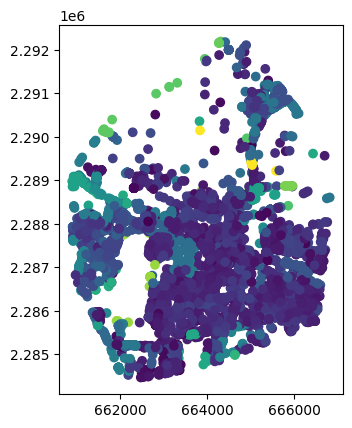

In [22]:
denue_gdf.plot('d_mean')

## Kernel density analysis

#### Single block test

In [23]:
idx_max = denue_gdf.groupby('cvegeo_mza').count().reset_index().idxmax().id
cvegeo_max = denue_gdf.groupby('cvegeo_mza').count().reset_index().iloc[idx_max].cvegeo_mza # gather the block with the most denue points
cvegeo_max

'1412000011189001'

In [24]:
block_test = block_gdf.loc[block_gdf.cvegeo_mza==cvegeo_max].copy()

denue_test = denue_gdf.loc[denue_gdf.cvegeo_mza==cvegeo_max].copy()
denue_test = denue_test.reset_index(drop=True)

print(denue_test.shape)
denue_test.head(2)

(256, 17)


,id,cve_ent,cve_loc,manzana,cve_mun,latitud,longitud,codigo_act,ageb,per_ocu,geometry,tipo_act,per_ocu_num,cvegeo_mza,cnt_geometry,distancia,d_mean
0,1703164,14,0001,001,120,20.675187,-103.404924,311520,1189,0 a 5 personas,POINT (666146.614 2287017.031),Industria,3,1412000011189001,POINT (666134.393 2286859.171),158.332429,165.229558
1,1655423,14,0001,001,120,20.675187,-103.404924,323119,1189,0 a 5 personas,POINT (666146.614 2287017.031),Industria,3,1412000011189001,POINT (666134.393 2286859.171),158.332429,165.229558


In [25]:
denue_test.per_ocu_num.unique()

array([  3,  40,   8,  20, 175,  75])

In [26]:
# Ejecutar el KDE solo sobre esos puntos
spatial_kernel_density(
    points=denue_test,
    radius = denue_test['d_mean'].mean()/2,
    output_path="../../data/processed/prediccion_uso_suelo/figureskde_manzana_prueba.tif",
    output_pixel_size=5,
    output_driver="GTiff",
    weight_col="per_ocu_num", # Número de personas por ocupación
)

### Iterative analysis

Analysis for every block and economic activity classification

In [ ]:
output_dir = '../../data/processed/prediccion_uso_suelo/kde_output/'
for idx, manzana in block_gdf.iterrows():
    # Filtrar puntos DENUE dentro de la manzana y con la actividad deseada
    cvegeo_mza = block_gdf.loc[idx].cvegeo_mza
    denue_block = denue_gdf.loc[denue_gdf.cvegeo_mza == cvegeo_mza].copy()

    # Saltar si no hay puntos que cumplan ambos criterios
    if denue_block.empty:
        continue

    # Nombre de salida con ID y nombre de actividad
    for act in denue_block.tipo_act.unique():
        output_file = f"{output_dir}kde_mnz_{cvegeo_mza}_{act}.tif"
        denue_act = denue_block.loc[denue_block.tipo_act==act].copy()
        denue_act = denue_act.reset_index(drop=True)

    
        # Ejecutar el KDE
        spatial_kernel_density(
            points=denue_act,
            radius = (denue_block['d_mean'].mean() / 2),
            output_path=output_file,
            output_pixel_size=1.0,
            output_driver="GTiff",
            weight_col="per_ocu_num",
        )
